In [1]:
#Import relevant libraries
import os
import random
import numpy as np
import cv2
from skimage.feature import SIFT, ORB, fisher_vector, learn_gmm
from skimage.transform import resize

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

from helper_functions import accuracy_fn

import requests
from pathlib import Path 

from timeit import default_timer as timer 

from tqdm.auto import tqdm

In [2]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


# Phase 1: Dataset Preparation

In [3]:
#Function to pick out random classes from the dataset
def get_classes(path, num):
    
    image_dir = os.listdir(path) #Path directory to classes
    
    #Classes to be skipped as they contain images that SIFT and ORB cannot process as they are
    remove_SIFT = ['n02190166', 'n01784675','n01910747','n02231487','n02233338','n02236044',
              'n02113799','n02124075','n02125311','n02321529','n01917289','n02669723',
             'n02815834','n01855672','n02165456','n01945685','n01950731','n02791270','n02892201','n02906734','n02909870','n02058221'
             ,'n03026506','n01644900','n02085620','n02085620','n02423022','n01698640']

    remove_ORB = ['n02321529','n01698640', 'n02909870', 'n02906734', 'n03126707','n0232152','n02480495','n02233338','n01910747',
                 'n03160309', 'n02730930','n01945685','n02788148','n02226429','n02437312','n03026506','n03201208','n02999410','n01882714',
                 'n02963159', 'n03250847']
    
    image_dir_SIFT = [x for x in image_dir if x not in remove_SIFT]

    image_dir_ORB = [x for x in image_dir if x not in remove_ORB]

    class_list_SIFT = random.sample(image_dir_SIFT, num) #Random selection of classes picked out

    class_list_ORB = random.sample(image_dir_ORB, num)

    return class_list_SIFT, class_list_ORB

In [4]:
def train_test(path, num):

    class_list = get_classes(path, num) #Retrieves the random classes
    print(f"{len(class_list[0])} classes were returned:\n{class_list[0]} for SIFT")

    train_list = [[] for x in range(len(class_list[0]))] #Creates a list of lists where each nested list corresponds to a class
    test_list = [[] for x in range(len(class_list[0]))]

    train_labels = np.zeros(1)
    test_labels = np.zeros(1)
    
    for i, cl in enumerate (class_list[0]): #Iterate through each class 

        class_path = path + cl + '/images/'
        image_dir = os.listdir(class_path) #Path directory to images within the class
        train_dir = image_dir[0:400] #First 400 images added to training set and last 100 to test set
        test_dir = image_dir[400:]

        #Iterate through all images and create a full path directory to that image and add to list
        #All images can then be easily accessed
        for j, train in enumerate (train_dir): 
            img_path = os.path.join(class_path, train)
            train_dir[j] = img_path

        for k, test in enumerate (test_dir):
            img_path = os.path.join(class_path, test)
            test_dir[k] = img_path
            
        train_list[i] = train_dir
        test_list[i] = test_dir

        train_labels = np.append(train_labels, np.full(len(train_dir), i))
        test_labels = np.append(test_labels, np.full(len(test_dir), i))

    train_labels = train_labels[1:]
    test_labels = test_labels[1:]
        
    return train_list, test_list, train_labels, test_labels

In [5]:
#Seperate train test function for ORB as the classes used differ from SIFT
def train_test_ORB(path, num):

    class_list = get_classes(path, num) #Retrieves the random classes
    
    class_list_actual = ['n01742172', 'n03160309', 'n02509815', 'n02802426', 'n01944390', 'n02395406', 'n01917289', 'n01784675', 'n02814533', 'n02190166', 'n02927161', 'n02917067', 'n02481823', 'n01882714', 'n02950826']
    print(f"{len(class_list[1])} classes were returned:\n{class_list[1]} for ORB")

    train_list = [[] for x in range(len(class_list[1]))] #Creates a list of lists where each nested list corresponds to a class
    test_list = [[] for x in range(len(class_list[1]))]

    train_labels = np.zeros(1)
    test_labels = np.zeros(1)
    
    for i, cl in enumerate (class_list[1]): #Iterate through each class 

        class_path = path + cl + '/images/'
        image_dir = os.listdir(class_path) #Path directory to images within the class
        train_dir = image_dir[0:400] #First 400 images added to training set and last 100 to test set
        test_dir = image_dir[400:]

        #Iterate through all images and create a full path directory to that image and add to list
        #All images can then be easily accessed
        for j, train in enumerate (train_dir): 
            img_path = os.path.join(class_path, train)
            train_dir[j] = img_path

        for k, test in enumerate (test_dir):
            img_path = os.path.join(class_path, test)
            test_dir[k] = img_path
            
        train_list[i] = train_dir
        test_list[i] = test_dir

        train_labels = np.append(train_labels, np.full(len(train_dir), i))
        test_labels = np.append(test_labels, np.full(len(test_dir), i))

    train_labels = train_labels[1:]
    test_labels = test_labels[1:]
        
    return train_list, test_list, train_labels, test_labels

In [6]:
random.seed(42)

image_path = 'TinyImageNet100/TinyImageNet100/'
num_classes = 15

#Train and test image lists and labels obtained for SIFT model
train_list, test_list, train_labels, test_labels = train_test(image_path, num_classes)
#Train and test image lists and labels obtained for ORB model
train_list_ORB, test_list_ORB, train_labels_ORB, test_labels_ORB = train_test_ORB(image_path, num_classes)

15 classes were returned:
['n02056570', 'n01641577', 'n02480495', 'n02403003', 'n02281406', 'n02099601', 'n02002724', 'n01983481', 'n02843684', 'n01742172', 'n03201208', 'n01768244', 'n03089624', 'n03250847', 'n02410509'] for SIFT
15 classes were returned:
['n01784675', 'n02927161', 'n02236044', 'n02423022', 'n02977058', 'n02099712', 'n01774384', 'n01742172', 'n02124075', 'n03089624', 'n03179701', 'n02950826', 'n01917289', 'n02486410', 'n02206856'] for ORB


In [7]:
train_list[0]

['TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_0.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_1.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_10.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_100.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_101.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_102.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_103.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_104.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_105.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_106.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_107.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_108.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_109.JPEG',
 'TinyImageNet100/TinyImageNet100/n02056570/images/n02056570_11.JPEG'

# Phase 2: Hand-Crafted Image Classification

In [8]:
def GetClusterCentres_SIFT(img_paths,num_words):

    num_classes = len(img_paths)
    
    sift_des = SIFT() #Using the SIFT model
    des_list = [[] for x in range(num_classes)] #Descriptor list where each index will contain all descriptors for given image
    key_list = [[] for x in range(num_classes)]
    des_matrix = [np.zeros((1,128)) for x in range(num_classes)] #Will contain all descriptors for all images stacked on top of each other

    for i in range(num_classes): #Iterate through all the classes
        
        for paths in img_paths[i]:
            
            img = cv2.imread(paths) #Read in the image from img_paths
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #Turn image gray
            sift_des.detect_and_extract(img_gray) #Extract the keypoints and descriptors 
            keypoints = sift_des.keypoints
            descriptors = sift_des.descriptors
            #If the descriptor around does contain values then add to des_matrix
            if descriptors is not None:
                des_matrix[i] = np.row_stack((des_matrix[i], descriptors))
            #Append descriptor to list
            des_list[i].append(descriptors)
            key_list[i].append(keypoints)

    all_centres = [[] for x in range(num_classes)]
    
    #Ignore first row as it only contains zeros
    for i in range(num_classes):
        des_matrix[i] = des_matrix[i][1:, :]

        kmeans = KMeans(n_clusters=num_words, random_state=33)
        kmeans.fit(des_matrix[i])
        centres = kmeans.cluster_centers_
        all_centres[i] = centres
    
    return all_centres,des_list, key_list

In [9]:
def GetClusterCentres_ORB(img_paths,num_words):

    num_classes = len(img_paths)
    
    orb_des = ORB() #Using the ORB model
    des_list = [[] for x in range(num_classes)] #Descriptor list where each index will contain all descriptors for given image
    des_matrix = [np.zeros((1,256)) for x in range(num_classes)] #Will contain all descriptors for all images stacked on top of each other

    for i in range(num_classes): #Iterate through all the classes
            
        for paths in img_paths[i]:
            
            img = cv2.imread(paths) #Read in the image from img_paths
            img = cv2.resize(img, (80,80))
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #Turn image gray
            orb_des.detect_and_extract(img_gray) #Extract the keypoints and descriptors 
            keypoints = orb_des.keypoints
            descriptors = (orb_des.descriptors).astype(np.float32)
            
            #If the descriptor around does contain values then add to des_matrix
            if descriptors is not None:
                des_matrix[i] = np.row_stack((des_matrix[i], descriptors))
            #Append descriptor to list
            des_list[i].append(descriptors)

    all_centres = [[] for x in range(num_classes)]
    
    #Ignore first row as it only contains zeros
    for i in range(num_classes):
        des_matrix[i] = des_matrix[i][1:, :]

        kmeans = KMeans(n_clusters=num_words, random_state=33)
        kmeans.fit(des_matrix[i])
        centres = kmeans.cluster_centers_
        all_centres[i] = centres
    
    return all_centres,des_list

In [10]:
#Number of words to describe each image
num_words = 10

centres_SIFT, des_list_train_SIFT, key_list_train_SIFT = GetClusterCentres_SIFT(train_list, num_words = num_words)
centres_SIFT, des_list_test_SIFT, key_list_test_SIFT = GetClusterCentres_SIFT(test_list, num_words = num_words)

centres_ORB, des_list_train_ORB = GetClusterCentres_ORB(train_list_ORB, num_words = num_words)
centres_ORB, des_list_test_ORB = GetClusterCentres_ORB(test_list_ORB, num_words = num_words)

In [11]:
#Function is applied to each image through each iteration
def des2feature_SIFT(des,num_words,centures):

    #The 10 words to describe the image (histogram). Ok, so not actuals words, each index corresponds to particular feature.
    img_feature_vec=np.zeros((1,num_words),'float32')

    #des.shape[0] is the number of descriptor arrays for given image. So, iterating through each layer of descriptor
    for i in range(des.shape[0]):
        feature_k_rows=np.ones((num_words,128),'float32') #Matrix created to align with number of centres (10
        feature=des[i] #ith layer of descriptor
        feature_k_rows=feature_k_rows*feature
        feature_k_rows=np.sum((feature_k_rows-centures)**2,1) #computes the squared difference between the descriptor and each cluster center. Then compute sum of squared differences 
        
        index=np.argmin(feature_k_rows) #Finds index of cluster centre closest to descriptor
        img_feature_vec[0][index]+=1 #Increment count of corresponding cluster in histogram
        
    return img_feature_vec

In [12]:
#Function is applied to each image through each iteration
def des2feature_ORB(des,num_words,centures):

    #The 10 words to describe the image (histogram). Ok, so not actuals words, each index corresponds to particular feature.
    img_feature_vec=np.zeros((1,num_words),'float32')

    #des.shape[0] is the number of descriptor arrays for given image. So, iterating through each layer of descriptor
    for i in range(des.shape[0]):
        feature_k_rows=np.ones((num_words,256),'float32') #Matrix created to align with number of centres (10
        feature=des[i] #ith layer of descriptor
        feature_k_rows=feature_k_rows*feature
        feature_k_rows=np.sum((feature_k_rows-centures)**2,1) #computes the squared difference between the descriptor and each cluster center. Then compute sum of squared differences 
        
        
        index=np.argmin(feature_k_rows) #Finds index of cluster centre closest to descriptor
        img_feature_vec[0][index]+=1 #Increment count of corresponding cluster in histogram

    return img_feature_vec

In [13]:
def get_all_features_SIFT(des_list,num_words, centres):

    #This will contain all image feature vectors. 21 rows (because 21 images) and 10 columns 
    allvec= [(np.zeros((len(des_list[0]),num_words),'float32')) for x in range(len(des_list))]
    
    for i in range(len(des_list)):
        
        #Iterate through each image
        for idx, j in enumerate (des_list[i]):
            
            if j.any()!=None:
                #Each iteration adds set of 10 words for each image. 
                allvec[i][idx]=des2feature_SIFT(centures=centres[i],des=j,num_words=num_words)
            
    return allvec

In [14]:
def get_all_features_ORB(des_list,num_words, centres):

    #This will contain all image feature vectors. 21 rows (because 21 images) and 10 columns 
    allvec= [(np.zeros((len(des_list[0]),num_words),'float32')) for x in range(len(des_list))]
    
    for i in range(len(des_list)):
        
        #Iterate through each image
        for idx, j in enumerate (des_list[i]):
            if j is not None and j.size > 0:
                #Each iteration adds set of 10 words for each image. 
                allvec[i][idx]=des2feature_ORB(centures=centres[i],des=j,num_words=num_words)
            
    return allvec

In [15]:
def fisher_vec(train_descriptors, test_descriptors, train_targets, test_targets):

    b = 0
    prediction_arr = []
    for i in range(len(train_descriptors)):
        print(i)
        k = 16
        gmm = learn_gmm(train_descriptors[i], n_modes=k)

        training_fvs = np.array([fisher_vector(descriptor_mat, gmm) for descriptor_mat in train_descriptors[i]])

        test_fvs = np.array([fisher_vector(descriptor_mat, gmm) for descriptor_mat in test_descriptors[i]])

        svm = LinearSVC().fit(training_fvs, train_targets[b: b + 400])
        
        predictions = svm.predict(testing_fvs)

        prediction_arr.append(predictions)

        b += 400

    print(prediction_arr)
    print(classification_report(test_targets, predictions))

    ConfusionMatrixDisplay.from_estimator(
        svm,
        testing_fvs,
        test_targets,
        cmap=plt.cm.Blues,
    )
    
    plt.show()

In [16]:
img_features_train_SIFT = get_all_features_SIFT(des_list=des_list_train_SIFT,num_words=num_words, centres = centres_SIFT)
img_features_test_SIFT = get_all_features_SIFT(des_list=des_list_test_SIFT,num_words=num_words, centres = centres_SIFT)

#Feature vectors for each image concatenated into one array to apply Linear SVC
img_features_train_SIFT = np.concatenate(np.array(img_features_train_SIFT), axis = 0)
img_features_test_SIFT = np.concatenate(np.array(img_features_test_SIFT), axis = 0)

In [17]:
img_features_train_ORB =get_all_features_ORB(des_list=des_list_train_ORB,num_words=num_words, centres = centres_ORB)
img_features_test_ORB =get_all_features_ORB(des_list=des_list_test_ORB,num_words=num_words, centres = centres_ORB)

img_features_train_ORB = np.concatenate(np.array(img_features_train_ORB), axis = 0)
img_features_test_ORB = np.concatenate(np.array(img_features_test_ORB), axis = 0)

CLASSIFICATION REPORT:
15 class image classification using SIFT
              precision    recall  f1-score   support

         0.0       0.24      0.29      0.26       100
         1.0       0.15      0.10      0.12       100
         2.0       0.21      0.15      0.18       100
         3.0       0.30      0.66      0.41       100
         4.0       0.29      0.21      0.24       100
         5.0       0.20      0.08      0.11       100
         6.0       0.13      0.03      0.05       100
         7.0       0.27      0.41      0.33       100
         8.0       0.24      0.04      0.07       100
         9.0       0.30      0.24      0.27       100
        10.0       0.30      0.27      0.29       100
        11.0       0.22      0.36      0.27       100
        12.0       0.38      0.64      0.48       100
        13.0       0.18      0.16      0.17       100
        14.0       0.30      0.38      0.33       100

    accuracy                           0.27      1500
   macro avg    

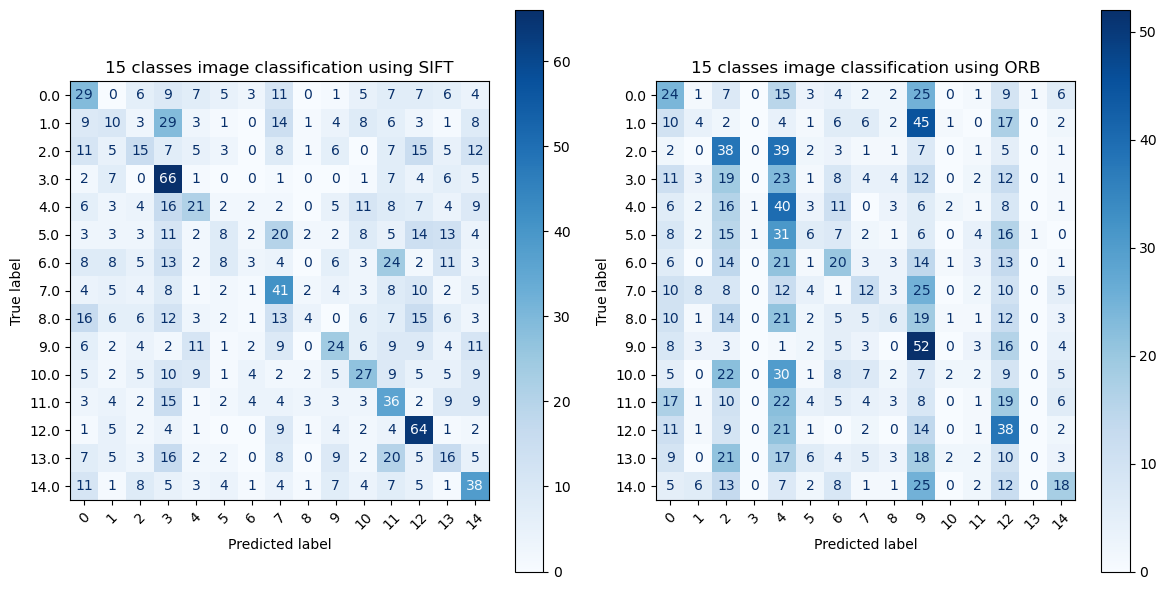

In [18]:
#Applying Support Vector Machine to feature vectors obtained using SIFT 
svm_SIFT = LinearSVC().fit(img_features_train_SIFT, train_labels)
#Predict target labels from test images
predictions_SIFT = svm_SIFT.predict(img_features_test_SIFT)

print(f"CLASSIFICATION REPORT:\n{num_classes} class image classification using SIFT\n" + classification_report(test_labels, predictions_SIFT))
#Applying Support Vector Machine to feature vectors obtained using ORB
svm_ORB = LinearSVC().fit(img_features_train_ORB, train_labels_ORB)
#Predict target labels from test images
predictions_ORB = svm_ORB.predict(img_features_test_ORB)

print(f"CLASSIFICATION REPORT:\n{num_classes} class image classification using ORB\n" + classification_report(test_labels, predictions_ORB))

fig, ax = plt.subplots(1,2, figsize = (12,6))

ConfusionMatrixDisplay.from_estimator(
    svm_SIFT,
    img_features_test_SIFT,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax[0]
)

ax[0].set_title(f"{num_classes} classes image classification using SIFT")
ax[0].set_xticklabels(range(15),rotation = 45)

ConfusionMatrixDisplay.from_estimator(
    svm_ORB,
    img_features_test_ORB,
    test_labels_ORB,
    cmap=plt.cm.Blues,
    ax=ax[1]
)

ax[1].set_title(f"{num_classes} classes image classification using ORB")
ax[1].set_xticklabels(range(15),rotation = 45)
plt.tight_layout()
plt.show()

In [19]:
#fisher_vec(des_list_train_ORB, des_list_test_ORB, train_labels_ORB, test_labels_ORB)

# Phase 3: Neural Network Image Classification

In [20]:
def NN_data_preprocess_train(data, data_labels, batch):

    #One transform for transforming image to tensor and one for normalizing
    transform_ToTen = transforms.ToTensor()
    transform_Norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    data_list = [] #List for appending accepted images
    labels_list = [] #List for appending the corressponding labels

    data = np.array(data).flatten().tolist() #Flattening training list so all paths can be iterated through at once
    data_labels = data_labels.tolist()
    
    for idx, path in enumerate(data):
        #image loaded using PIL and transformed to tensor
        image = Image.open(path)
        image = transform_ToTen(image)

        if image.shape[0] == 3: #Check that image is RBG. Shape could only be checked for non-normalized image
            #Image normalized and added to list along with label
            image = transform_Norm(image)
            data_list.append(image)
            labels_list.append(data_labels[idx])
            
    data_tensor = torch.stack(data_list)
    labels_tensor = torch.tensor(labels_list).long()
    
    dataset = TensorDataset(data_tensor, labels_tensor) #images and labels combined into one dataset for easier examination in NN

    dataloader = DataLoader(dataset, batch_size=batch, shuffle=True) #Data split into batches of size 32

    return dataloader

In [21]:
def NN_data_preprocess_test(data, data_labels, batch):

    #One transform for transforming image to tensor and one for normalizing
    transform_ToTen = transforms.ToTensor()
    transform_Norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    data_list = [] #List for appending accepted images
    labels_list = [] #List for appending the corressponding labels

    data = np.array(data).flatten().tolist() #Flattening test list so all paths can be iterated through at once
    data_labels = data_labels.tolist()
    
    for idx, path in enumerate(data):
        #image loaded using PIL and transformed to tensor
        image = Image.open(path)
        image = transform_ToTen(image)

        if image.shape[0] == 3: #Check that image is RBG. Shape could only be checked for non-normalized image
            #Image normalized and added to list along with label
            image = transform_Norm(image)
            data_list.append(image)
            labels_list.append(data_labels[idx])
            
    data_tensor = torch.stack(data_list)
    labels_tensor = torch.tensor(labels_list).long()
    
    dataset = TensorDataset(data_tensor, labels_tensor) #images and labels combined into one dataset for easier examination in NN

    dataloader = DataLoader(dataset, batch_size=batch, shuffle=False) #Data split into batches of size 32

    return dataloader

In [22]:
train_dataloader = NN_data_preprocess_train(train_list, train_labels, 32)
test_dataloader = NN_data_preprocess_test(test_list, test_labels, 32)

In [23]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


Image size: torch.Size([64, 64, 3])
Label: 4, label size: torch.Size([])


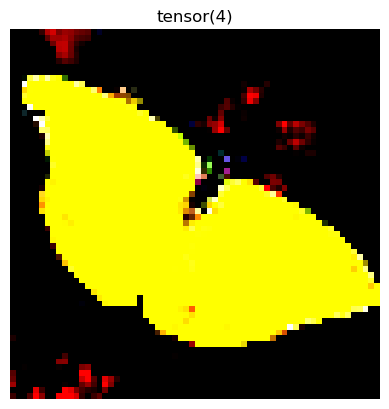

In [24]:
#Show a random image from a random class
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
img = img.permute(1,2,0)
plt.imshow(img.squeeze())
plt.title(label)
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [25]:
#Implements a progress bar
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds\n")
    return total_time

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               epoch, train_loss_list, train_acc_list,
               device: torch.device = device):

    #Only print updates every 10 epochs 
    if epoch % 10 == 0:
        print(f"Training Epoch: {epoch}")
        
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        model.train()

        #Forward pass to make y prediction
        y_pred = model(X)

        #Calculate loss between predicted and true y value 
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        #Resets the gradients to zero
        optimizer.zero_grad()

        #Backward pass to calculate gradients
        loss.backward()

        #Optimizer step to adjust weights according to gradient
        optimizer.step()

        # Print out how many samples have been seen
        if epoch % 10 == 0:
            if batch % 30 == 0:
                print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    #Add loss and accuracy to list to track them after each epoch
    train_loss_list.append(train_loss.item())
    train_acc_list.append(train_acc)
    
    if epoch % 10 == 0:
        print(f"\nTrain Loss: {train_loss:.5f}\n")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              epoch, test_loss_list, test_acc_list, early_stop_patience, best_val_loss, early_stop_counter,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            #Forward pass
            test_pred = model(X)
            
            #Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        test_loss_list.append(test_loss.item())
        test_acc_list.append(test_acc)

        if epoch % 10 == 0:
            print(f"\nTest Loss: {test_loss:.5f}\n")

In [27]:
torch.manual_seed(42)

class NN_Classification(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Dropout(p = 0.5), #50% probability of node being zeroed to improve models ability to generalise 
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.Softmax(dim=1) #Softmax activation function to introduce non-linearity
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Need to setup model with input parameters
model_0 = NN_Classification(input_shape=12288, # one for every pixel 
    hidden_units=128, # how many units in the hidden layer
    output_shape=num_classes # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

# Setup loss function and optimizer
import torch.optim.lr_scheduler as lr_scheduler
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.001, weight_decay=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma = 0.1)

# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 150
loss_list=[]

train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

#Patience level to determine when model stops learning depending how far validation strays from training accuracy
early_stop_patience = 1
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in tqdm(range(epochs)):
        
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_func,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        epoch=epoch,
        train_loss_list = train_loss_list,
        train_acc_list = train_acc_list
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_func,
        accuracy_fn=accuracy_fn,
        device=device,
        epoch=epoch,
        test_loss_list = test_loss_list,
        test_acc_list = test_acc_list,
        early_stop_patience = early_stop_patience,
        best_val_loss = best_val_loss,
        early_stop_counter = early_stop_counter
    )

    if test_loss_list[epoch] < best_val_loss:
        best_val_loss = test_loss_list[epoch]
        early_stop_counter = 0  # Reset the counter if validation loss improves
    else:
        early_stop_counter += 1  # Increment the counter if no improvement
    
    # Check for early stopping
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch: 0
Looked at 0/5939 samples
Looked at 960/5939 samples
Looked at 1920/5939 samples
Looked at 2880/5939 samples
Looked at 3840/5939 samples
Looked at 4800/5939 samples
Looked at 5760/5939 samples

Train Loss: 2.70803


Test Loss: 2.70752

Training Epoch: 10
Looked at 0/5939 samples
Looked at 960/5939 samples
Looked at 1920/5939 samples
Looked at 2880/5939 samples
Looked at 3840/5939 samples
Looked at 4800/5939 samples
Looked at 5760/5939 samples

Train Loss: 2.70258


Test Loss: 2.70191

Training Epoch: 20
Looked at 0/5939 samples
Looked at 960/5939 samples
Looked at 1920/5939 samples
Looked at 2880/5939 samples
Looked at 3840/5939 samples
Looked at 4800/5939 samples
Looked at 5760/5939 samples

Train Loss: 2.68606


Test Loss: 2.68360

Training Epoch: 30
Looked at 0/5939 samples
Looked at 960/5939 samples
Looked at 1920/5939 samples
Looked at 2880/5939 samples
Looked at 3840/5939 samples
Looked at 4800/5939 samples
Looked at 5760/5939 samples

Train Loss: 2.65101


Test 

Training Accuracy: 30.41171477079796
Test Accuracy: 26.80851063829787
Training Loss: 2.5290286540985107
Test Loss: 2.5546393394470215


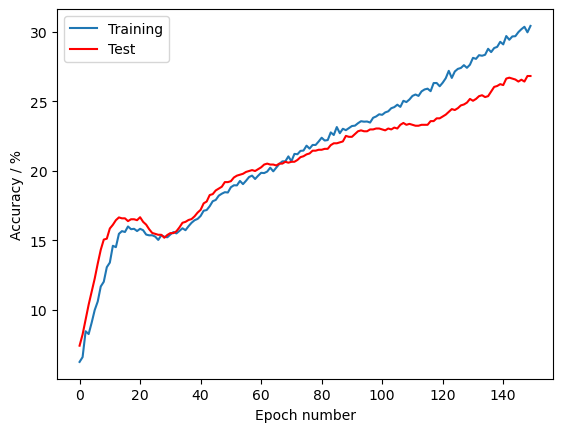

In [28]:
print(f"Training Accuracy: {train_acc_list[-1]}")
print(f"Test Accuracy: {test_acc_list[-1]}")

print(f"Training Loss: {train_loss_list[-1]}")
print(f"Test Loss: {test_loss_list[-1]}")

plt.plot(np.arange(len(train_acc_list)), train_acc_list, label = 'Training')
plt.plot(np.arange(len(test_acc_list)), test_acc_list,'r', label = 'Test')
plt.xlabel("Epoch number")
plt.ylabel("Accuracy / %")
plt.legend()
plt.show()

Model Name: NN_Classification
loss_fn: 2.5546393394470215
Accuracy: 26.80851063829787


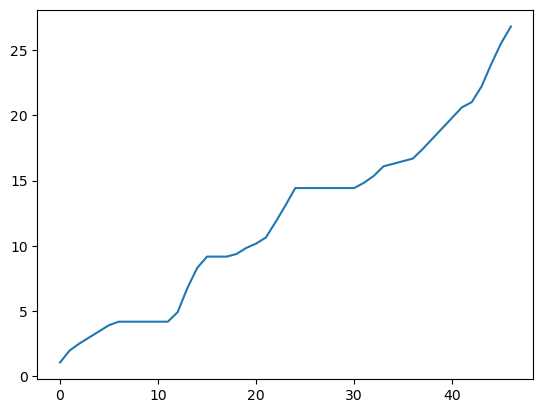

In [29]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    loss, acc = 0, 0
    acc_list = []
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            
            y = y.long()
            
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
            acc_list.append(acc)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

        acc_list = np.array(acc_list)
        acc_list /= len(data_loader)
        
    return (model.__class__.__name__, loss.item(), acc, acc_list)

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
                             loss_fn=loss_func, accuracy_fn=accuracy_fn)

print(f"Model Name: {model_0_results[0]}\nloss_fn: {model_0_results[1]}\nAccuracy: {model_0_results[2]}")

plt.plot(np.arange(0,len(model_0_results[3])), model_0_results[3])
plt.show()

# Phase 4: Image Classification using Convolutional Neural Network

In [30]:
def CNN_data_preprocess_train(data, data_labels, batch):

    #One transform for transforming image to tensor and one for normalizing
    transform_ToTen = transforms.ToTensor()
    transform_Norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    data_list = [] #List for appending accepted images
    labels_list = [] #List for appending the corressponding labels

    data = np.array(data).flatten().tolist() #Flattening training list so all paths can be iterated through at once
    data_labels = data_labels.tolist()
    
    for idx, path in enumerate(data):
        #image loaded using PIL and transformed to tensor
        image = Image.open(path)
        image = transform_ToTen(image)

        if image.shape[0] == 3: #Check that image is RBG. Shape could only be checked for non-normalized image
            #Transforms applied to images and added to list along with label
            image = train_transform(image)
            data_list.append(image)
            labels_list.append(data_labels[idx])
            
    data_tensor = torch.stack(data_list)
    labels_tensor = torch.tensor(labels_list).long()
    
    dataset = TensorDataset(data_tensor, labels_tensor) #images and labels combined into one dataset for easier examination in NN

    dataloader = DataLoader(dataset, batch_size=batch, shuffle=True) #Data split into batches of size 32

    return dataloader

In [31]:
def CNN_data_preprocess_test(data, data_labels, batch):

    #One transform for transforming image to tensor and one for normalizing
    transform_ToTen = transforms.ToTensor()
    transform_Norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    data_list = [] #List for appending accepted images
    labels_list = [] #List for appending the corressponding labels

    data = np.array(data).flatten().tolist() #Flattening test list so all paths can be iterated through at once
    data_labels = data_labels.tolist()
    
    for idx, path in enumerate(data):
        #image loaded using PIL and transformed to tensor
        image = Image.open(path)
        image = transform_ToTen(image)

        if image.shape[0] == 3: #Check that image is RBG. Shape could only be checked for non-normalized image
            #Image normalized and added to list along with label
            image = transform_Norm(image)
            data_list.append(image)
            labels_list.append(data_labels[idx])
            
    data_tensor = torch.stack(data_list)
    labels_tensor = torch.tensor(labels_list).long()
    
    dataset = TensorDataset(data_tensor, labels_tensor) #images and labels combined into one dataset for easier examination in NN

    dataloader = DataLoader(dataset, batch_size=batch, shuffle=False) #Data split into batches of size 32

    return dataloader

In [32]:
train_dataloader_conv = CNN_data_preprocess_train(train_list, train_labels, 32)
test_dataloader_conv = CNN_data_preprocess_test(test_list, test_labels, 32)

In [33]:
# Create a convolutional neural network 
device = "cuda" if torch.cuda.is_available() else "cpu"
class Conv_NN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, #Takes the input image and applies hidden filters to it 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(), #Apply non-linearity so model can learn complex patterns
            nn.Conv2d(in_channels=hidden_units, #This second layer applies another layer of hidden filters to detect edges and features
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, #Reduces spatial dimension by half by taking max value in a 2x2 block
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        #Dummy tensor to compute final feature map size
        #This was added so that if anymore blocks were added that alter the image size then the classifier will dynamically know what image size to expect
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 64, 64)
            out = self.block_1(dummy_input)
            out = self.block_2(out)
            self.flattened_size = out.shape[1] * out.shape[2] * out.shape[3]  # (channels * height * width)

        self.classifier = nn.Sequential(
            nn.Flatten(), #Convert to 1D tensor
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(x.shape) #Import print statements to determine the shape of the image as it passes through layers
        x = self.block_2(x)
        #print(x.shape)
        
        x = self.classifier(x)
        #print(x.shape)
        return x

torch.manual_seed(42)
model_CNN = Conv_NN(input_shape=3, 
    hidden_units=128, 
    output_shape=num_classes).to(device)
model_CNN

loss_func_conv = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.SGD(params=model_CNN.parameters(), lr = 0.001)

torch.manual_seed(42)

# Measure time
train_time_start_model_CNN = timer()

# Train and test model 
epochs = 15
loss_list=[]

train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

early_stop_patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in tqdm(range(epochs)):
        
    train_step(data_loader=train_dataloader_conv, 
        model=model_CNN, 
        loss_fn=loss_func_conv,
        optimizer=optimizer_conv,
        accuracy_fn=accuracy_fn,
        device=device,
        epoch=epoch,
        train_loss_list = train_loss_list,
        train_acc_list = train_acc_list
    )
    test_step(data_loader=test_dataloader_conv,
        model=model_CNN,
        loss_fn=loss_func_conv,
        accuracy_fn=accuracy_fn,
        device=device,
        epoch=epoch,
        test_loss_list = test_loss_list,
        test_acc_list = test_acc_list,
        early_stop_patience = early_stop_patience,
        best_val_loss = best_val_loss,
        early_stop_counter = early_stop_counter
    )

    if test_loss_list[epoch] < best_val_loss:
        best_val_loss = test_loss_list[epoch]
        early_stop_counter = 0  # Reset the counter if validation loss improves
    else:
        early_stop_counter += 1  # Increment the counter if no improvement
    
    # Check for early stopping
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

train_time_end_model_CNN = timer()
total_train_time_model_CNN = print_train_time(start=train_time_start_model_CNN,
                                           end=train_time_end_model_CNN,
                                           device=device)



  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch: 0
Looked at 0/5939 samples
Looked at 960/5939 samples
Looked at 1920/5939 samples
Looked at 2880/5939 samples
Looked at 3840/5939 samples
Looked at 4800/5939 samples
Looked at 5760/5939 samples

Train Loss: 2.69825


Test Loss: 2.68174

Training Epoch: 10
Looked at 0/5939 samples
Looked at 960/5939 samples
Looked at 1920/5939 samples
Looked at 2880/5939 samples
Looked at 3840/5939 samples
Looked at 4800/5939 samples
Looked at 5760/5939 samples

Train Loss: 1.93094


Test Loss: 1.90535

Train time on cpu: 7775.536 seconds



In [36]:
torch.save(model_CNN, 'model_CNN')
torch.save(model_0, 'model_NN')
torch.save(svm_SIFT, 'svm_SIFT')

Training Accuracy: 42.31395019807583
Test Accuracy: 41.994680851063826
Training Loss: 1.7986027002334595
Test Loss: 1.8731683492660522


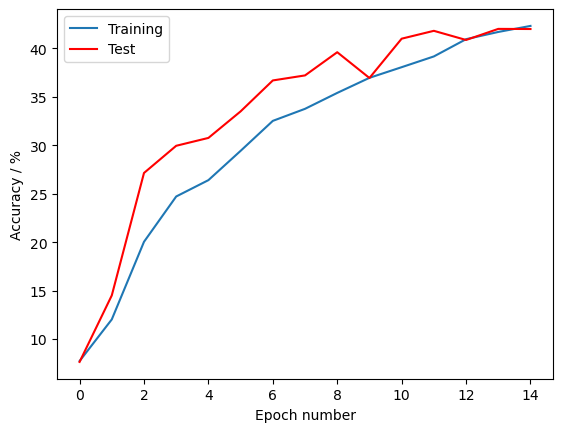

In [34]:
print(f"Training Accuracy: {train_acc_list[-1]}")
print(f"Test Accuracy: {test_acc_list[-1]}")

print(f"Training Loss: {train_loss_list[-1]}")
print(f"Test Loss: {test_loss_list[-1]}")

plt.plot(np.arange(len(train_acc_list)), train_acc_list, label = 'Training')
plt.plot(np.arange(len(test_acc_list)), test_acc_list,'r', label = 'Test')
plt.xlabel("Epoch number")
plt.ylabel("Accuracy / %")
plt.legend()
plt.show()

In [35]:
# Get model_2 results 
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

model_CNN_results = eval_model(
    model=model_CNN,
    data_loader=test_dataloader,
    loss_fn=loss_func,
    accuracy_fn=accuracy_fn
)
model_CNN_results

{'model_name': 'Conv_NN',
 'model_loss': 1.8731683492660522,
 'model_acc': 41.994680851063826}